In [1]:
import pickle
import random as rn
import time
import warnings
warnings.filterwarnings("ignore")
from abc import ABC, abstractmethod
from datetime import timedelta
from pathlib import Path
from tempfile import mkdtemp

import autokeras as ak
import h2o
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_model_summary as pms
import tensorflow as tf
import torch
from PIL import Image
from autokeras.utils import pickle_from_file
from h2o.automl import H2OAutoML
from keras.datasets import fashion_mnist
from numpy.random.mtrand import RandomState
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier

gpu_count = torch.cuda.device_count()
print(f"GPU count: {gpu_count}")
if gpu_count > 0:
    for i in range(gpu_count):
        print(f"{i}. {torch.cuda.get_device_name(i)}")

%matplotlib inline

Using TensorFlow backend.


Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


GPU count: 0

In [2]:
seed = 42
n_threads = 40
# dataset_name = "digits"
dataset_name = "fashion"
n_images = 0
# err_source = "noise"
err_source = "rotation"
# err_params = np.round(np.linspace(0, 16, num=6), 3)
# err_params = np.round(np.linspace(0, 255, num=6), 3)
err_params = np.linspace(0, 180, num=6)
time_limit_mins = 90
# model_name = "autokeras"
# model_name = "h2o"
model_name = "tpot"
augment = False
gpu = False

model_full_name = model_name
if augment:
    model_full_name += "_aug"
if gpu:
    model_full_name += "_gpu"

In [3]:
rn.seed(seed)
np.random.seed(seed)

if dataset_name == "digits":
    x, y = load_digits(return_X_y=True)
    y = y.astype(np.uint8)
    x = x.astype(np.uint8)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=RandomState(seed))
    s = np.sqrt(len(x[0])).astype(int)
else:
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    s = x_train.shape[1]
    x_train = x_train.reshape((len(x_train), s ** 2))
    x_test = x_test.reshape((len(x_test), s ** 2))

if n_images != 0:
    x_train = x_train[:n_images]
    y_train = y_train[:n_images]

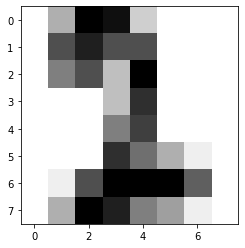

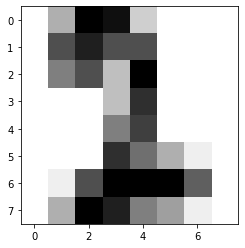

In [4]:
rn.seed(seed)
np.random.seed(seed)
random_state = RandomState(seed)

def show_images(arr):
    plt.imshow(arr.reshape(s, s), cmap="gray_r")
    plt.show()

def add_noise(arr, std):
    arr = arr.astype(float)
    arr += random_state.normal(scale=std, size=arr.shape)
    arr = np.clip(arr, 0, np.amax(x_test))
    arr = np.round(arr).astype(np.uint8)
    return arr

def rotate(arr, angle):
    arr = arr.reshape(s, s).astype(float)
    angle = random_state.uniform(-angle, angle)
    img = Image.fromarray(arr).rotate(angle)
    arr = np.asarray(img)
    arr = np.round(arr).flatten().astype(np.uint8)
    return arr

if err_source == "noise":
    error_generator = add_noise
    err_param_name = "std"
else:
    error_generator = rotate
    err_param_name = "max_angle"

err_x_train_list = [np.apply_along_axis(error_generator, 1, x_train, ep) for ep in err_params]
err_x_test_list = [np.apply_along_axis(error_generator, 1, x_test, ep) for ep in err_params]

show_images(x_train[1])
show_images(error_generator(x_train[1], err_params[-1]))

In [5]:
rn.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
torch.manual_seed(seed)

class AbstractModel(ABC):
    
    model = None
    time_train = np.nan
    
    def __init__(self, err_param_idx_train):
        self.err_param_idx_train = err_param_idx_train

    def prepare(self, x_train, y_train):
        model_description = f"{model_full_name}_{err_param_name}_{np.round(err_params[self.err_param_idx_train], 3)}_" \
                            f"time_limit_mins_{time_limit_mins}"
        model_path_prefix = f"models_{dataset_name}/model_{model_description}"
        summary_path = f"models_{dataset_name}/summary_{model_description}.txt"

        if Path(summary_path).is_file():
            self.load(model_path_prefix)
        else:
            self.fit(x_train, y_train)
            self.save(model_path_prefix)
            summary = self.get_summary(len(x_train))
            with open(summary_path, "w") as f:
                print(f"Actual train time: {str(self.time_train)}\n\n{summary}", file=f)

    @abstractmethod
    def fit(self, x_train, y_train):
        pass
    
    @abstractmethod
    def save(self, model_path_prefix):
        pass
    
    @abstractmethod
    def load(self, model_path_prefix):
        pass
        
    @abstractmethod    
    def get_summary(self, *args):
        pass
    
    @abstractmethod
    def predict(self, x_test, y_test):
        pass

    @abstractmethod
    def shutdown(self):
        pass

class AutoKerasModel(AbstractModel):
    
    def __init__(self, err_param_idx_train):
        super().__init__(err_param_idx_train)

    def fit(self, x_train, y_train):
        if augment:
            self.model = ak.ImageClassifier(augment=True, path=mkdtemp(dir="temp"), verbose=True)
        else:
            self.model = ak.ImageClassifier(augment=False, path=mkdtemp(dir="temp"), verbose=True)
        x_train = x_train.reshape((len(x_train), s, s, 1))
        time_start = time.time()
        self.model.fit(x_train, y_train, time_limit=60 * time_limit_mins)
        self.time_train = timedelta(seconds=np.round(time.time() - time_start))
    
    def load(self, model_path_prefix):
        self.model = pickle_from_file(f"{model_path_prefix}.pkl")
    
    def save(self, model_path_prefix):
        self.model.export_autokeras_model(f"{model_path_prefix}.pkl")
        
    def get_summary(self, n_train):
        return pms.summary(self.model.cnn.best_model.produce_model(), torch.zeros(1, 1, n_train, s ** 2))
    
    def predict(self, x_test, y_test):
        x_test = x_test.reshape((len(x_test), s, s, 1))
        y_pred = self.model.predict(x_test)
        return np.round(accuracy_score(y_true=y_test, y_pred=y_pred), 3)
    
    def shutdown(self):
        pass

class H2OAutoMLModel(AbstractModel):

    def __init__(self, err_param_idx_train):
        super().__init__(err_param_idx_train)
        h2o.init(name=f"#{rn.SystemRandom().randint(1, 2 ** 20)}", nthreads=n_threads)
        # h2o.no_progress()
    
    def fit(self, x_train, y_train):
        training_frame = h2o.H2OFrame(np.concatenate((x_train, y_train.reshape(-1, 1)), axis=1))
        x_cols = np.array(training_frame.columns)[:-1].tolist()
        y_cols = np.array(training_frame.columns)[-1].tolist()
        training_frame[y_cols] = training_frame[y_cols].asfactor()
        self.model = H2OAutoML(
            max_runtime_secs=60 * time_limit_mins, exclude_algos=["XGBoost"], seed=seed, verbosity="info"
        )
        time_start = time.time()
        self.model.train(x=x_cols, y=y_cols, training_frame=training_frame)
        self.time_train = timedelta(seconds=np.round(time.time() - time_start))
    
    def load(self, model_path_prefix):
        self.model = h2o.load_model(model_path_prefix)
    
    def save(self, model_path_prefix):
        temp_path = h2o.save_model(model=self.model.leader, path=f"models_{dataset_name}", force=True)
        source = Path(temp_path)
        target = Path(model_path_prefix)
        source.rename(target)

    def get_summary(self, n_train):
        leader_params = self.model.leader.params
        summary = "model_id:\n" + leader_params["model_id"]["actual"]["name"] + "\n\n"
        summary += "base_models:"
        if "base_models" in leader_params:
            for base_model in leader_params["base_models"]["actual"]:
                summary += "\n" + base_model["name"]
        return summary
    
    def predict(self, x_test, y_test):
        testing_frame = h2o.H2OFrame(np.concatenate((x_test, y_test.reshape(-1, 1)), axis=1))
        y_cols = np.array(testing_frame.columns)[-1].tolist()
        testing_frame[y_cols] = testing_frame[y_cols].asfactor()
        y_pred = self.model.predict(testing_frame).as_data_frame(header=False)["predict"].values.astype(int)
        return np.round(accuracy_score(y_true=y_test, y_pred=y_pred), 3)

    def shutdown(self):
        h2o.cluster().shutdown()

class TPOTModel(AbstractModel):

    def __init__(self, err_param_idx_train):
        super().__init__(err_param_idx_train)
    
    def fit(self, x_train, y_train):
        self.model = TPOTClassifier(
            max_time_mins=time_limit_mins, max_eval_time_mins=time_limit_mins, n_jobs=n_threads, random_state=seed,
            verbosity=2
        )
        time_start = time.time()
        self.model.fit(x_train, y_train)
        self.time_train = timedelta(seconds=np.round(time.time() - time_start))
    
    def load(self, model_path_prefix):
        with open(f"{model_path_prefix}.pkl", "rb") as f:
            self.model = pickle.load(f)
    
    def save(self, model_path_prefix):
        with open(f"{model_path_prefix}.pkl", "wb") as f:
            pickle.dump(self.model.fitted_pipeline_, f)

    def get_summary(self, n_train):
        summary = "Steps:"
        for i, step in enumerate(self.model.fitted_pipeline_.steps):
            summary += f"\n{i}. {str(step[1])}"
        return summary
    
    def predict(self, x_test, y_test):
        return round(self.model.score(x_test, y_test), 3)

    def shutdown(self):
        pass

In [6]:
rn.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
torch.manual_seed(seed)

scores = []
for err_param_idx_train, err_x_train in enumerate(err_x_train_list):
    if model_name == "autokeras":
        model = AutoKerasModel(err_param_idx_train)
    elif model_name == "h2o":
        model = H2OAutoMLModel(err_param_idx_train)
    elif model_name == "tpot":
        model = TPOTModel(err_param_idx_train)
    else:
        model = None
    model.prepare(err_x_train, y_train)
    for err_param_idx_test, err_x_test in enumerate(err_x_test_list):
        scores.append({
            f"train_{err_param_name}": np.round(err_params[err_param_idx_train]),
            f"test_{err_param_name}": np.round(err_params[err_param_idx_test]),
            "accuracy": model.predict(err_x_test, y_test),
        })
    model.shutdown()

In [7]:
scores_df = pd.DataFrame(scores)
scores_path = f"scores_{dataset_name}/{model_full_name}_{err_source}_time_limit_mins_{time_limit_mins}.pkl"
scores_df.to_pickle(scores_path)
scores_df

,train_max_angle,test_max_angle,accuracy
0,0.0,0.0,0.982
